# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 16:16:22--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.07s   

2021-03-07 16:16:23 (1.10 MB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 16:16:23--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

### Read in the one-hot encoded sequences and scores

In [3]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


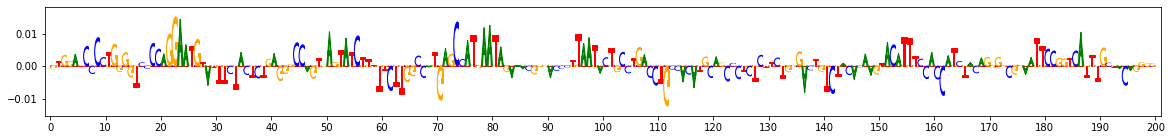

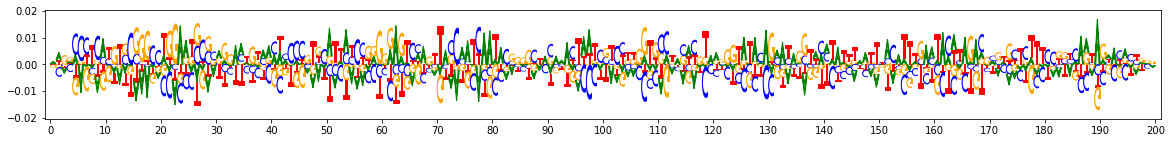

In [ ]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The `final_min_cluster_size` is set to 20 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

In [ ]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=4),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [ ]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

In [ ]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 205


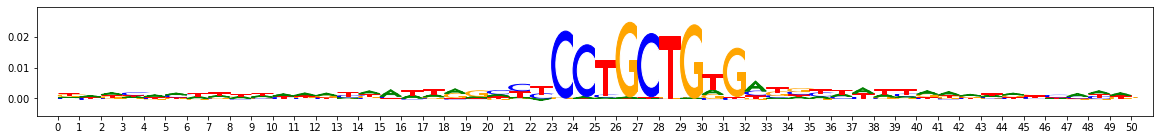

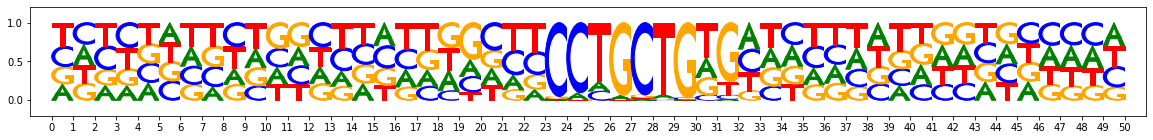

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 183


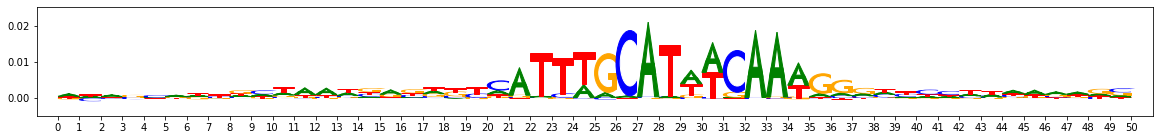

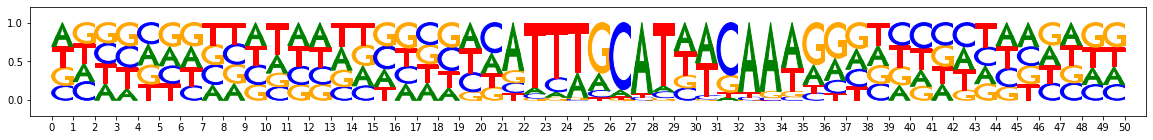

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 132


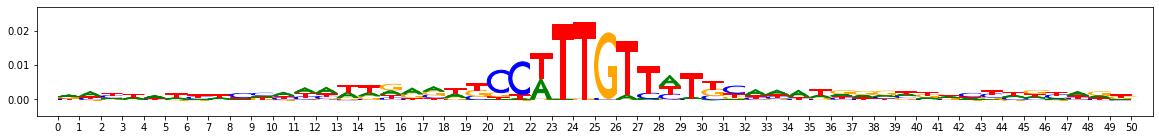

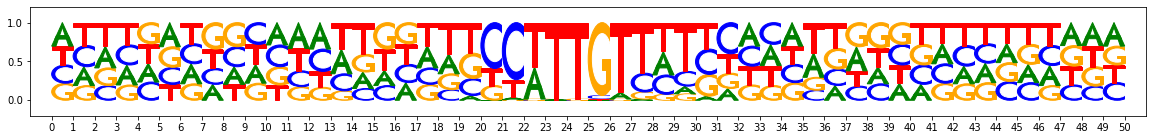

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 58


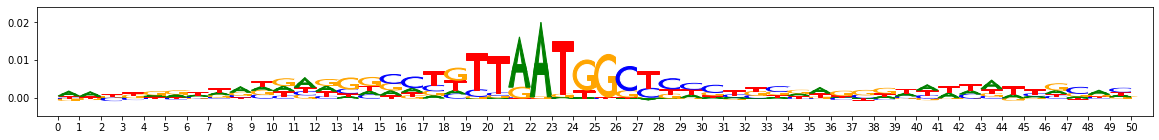

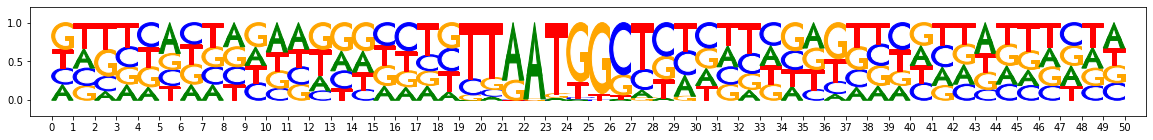

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 32


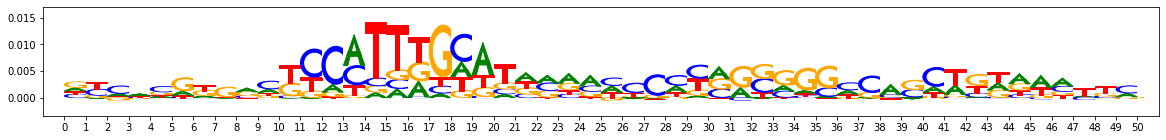

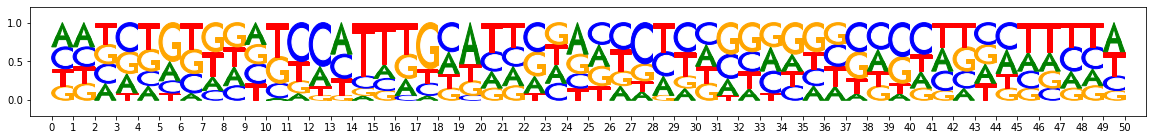

round 1 MEME-DISco motif number 5
num seqlets mapped to this motif: 11


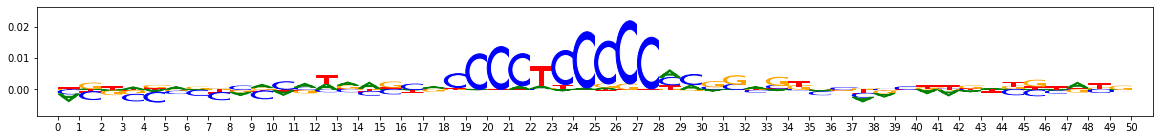

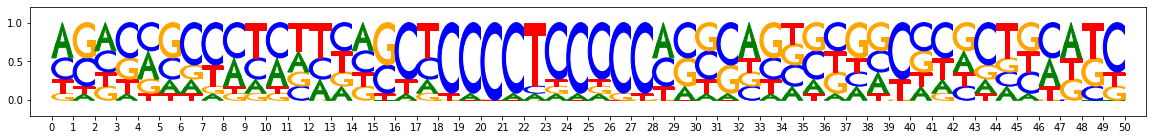

In [7]:
from modisco.visualization import viz_sequence
for round_idx in [1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[round_idx])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)